# ASTR-19 Individual Final Project

In this notebook, we will do the following:

5) Get the f105w band image of the Hubble Ultra Deep Field, which is called

hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits

You can download it from https://archive.stsci.edu/pub/hlsp/hudf12/.

6) Redo the tutorial steps in a second notebook, but on the UDF f105w image. How many sources do you find? Histogram their fluxes.

7) What are the mean, median, and standard deviation of the distribution of fluxes. What is the largest outlier in the distribution, where is it on the image, and how many standard deviations is it away from the mean? 

8) Download the f125w and f160w images of the HUDF at the same website, and make a 3-color false image of the UDF using RGB -> f160w, f125w, f105w. Save the image as a PNG.


In [7]:
# Import all needed modules
import astropy
import astropy.io.fits
import sep
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import rcParams

Now, we just need to define some stuff for matplotlib (like setting the figure size and that sort of stuff)

In [8]:
# additional setup for reading the test image and displaying plots
%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

Next, we load the image into the variable labelled data. Data is internally just a 2d np array - note since we're not dealing with RGBA images, but just black and white, the array does not need to be 3D. (as in Width_x, Height_y, Channels_z)

In [9]:
# read image into standard 2-d numpy array
astropy_image = astropy.io.fits.open("hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits")
data = astropy_image[0].data

# If this barfs with errors about non-native byte order, swap the endianness
data = data.byteswap(inplace=True).newbyteorder()


After that, we're just going to plot the image as is, just so we can see what's going on in it. This is of course going to be automatically annotated later on (to search for unique features) (we could also use OpenCV to do this, no?)

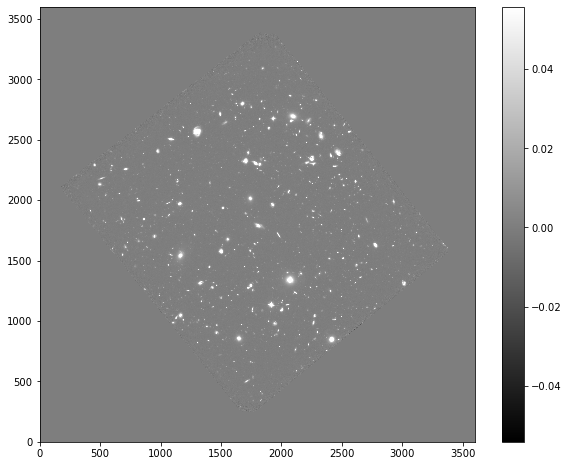

In [10]:
# show the image
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.savefig("1.png")
plt.colorbar();

Now, we subtract the background from the image (remove the noisefloor, to enable the features to stand out and be segmented more easily.)

This is done in multiple steps, firstly, we find the average of the background, in terms of avg color, then this is used to identify what the mean color is.


In [11]:
# evaluate background as 2-d array, same size as original image
bkg = sep.Background(data)
bkg_image = bkg.back()

Next, it's time to generate a picture of this averaged background or noies floor, note that it's been interpolated, so a lot of the fine noise isn't going to be there, which is why it looks smooth.

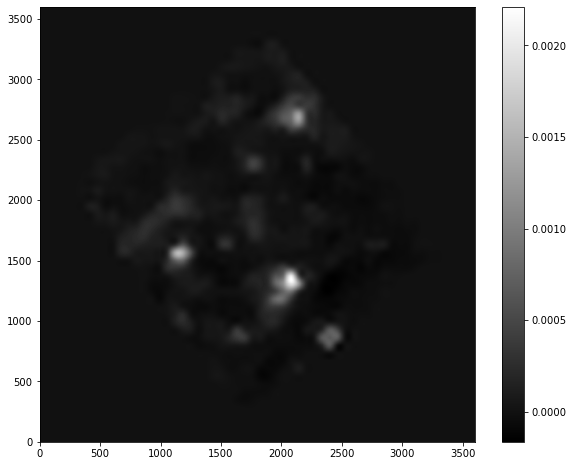

In [12]:
# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.savefig("2.png")
plt.colorbar();

After that, we're going to make the bkg we calculated into a 2d arr scaled to match the image dimensions.

In [13]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

Now, we can make another pretty graph showing that!

In [14]:
# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.savefig("3.png")
plt.colorbar();

Okay, now we're going to remove that background from the source image, so that it just contains the features standing out above the noise background.

In [15]:
# subtract the background
data_sub = data - bkg
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

Here, we can get a count of the total num features that were extraced.

In [16]:
# how many objects were detected
len(objects)

8643

Now, we're goint to draw elipses around the features that we spotted, and plot that on an image.

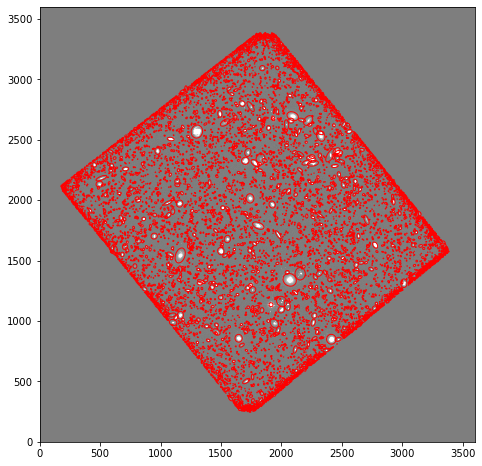

In [17]:
# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
plt.savefig("4.png")


Here, we will calculate the fluxes and error margins for the first ten features identified.

In [18]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 3.0, err=bkg.globalrms, gain=1.0)

In [19]:
# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877


Now, we're going to make a histogram of the fluxes, and calculate some other stats about the distrobution of values in the segmented features.

In [20]:
count, bins, ignored = plt.hist(flux, bins=25, alpha=0.7, color='pink', label='Residuals')
plt.yscale("log")
plt.xlabel('Flux')
plt.ylabel('Number Of Samples')
plt.title('Histogram of Fluxes')
plt.savefig('FluxHistogram.pdf')
plt.show()

Now, we're going to answer part 7:
    What are the mean, median, and standard deviation of the distribution of fluxes.

In [21]:
std_deviation = np.std(flux)
print(f"The std deviation of the fluxes is: {std_deviation}")

The std deviation of the fluxes is: 9.241925555851745


In [22]:
mean = np.mean(flux)
print(f"The mean flux is: {mean}")

The mean flux is: 0.3617466258281149


In [23]:
median = np.median(flux)
print(f"The median flux is: {median}")

The median flux is: 0.030954822942148894


What is the largest outlier in the distribution, where is it on the image, and how many standard deviations is it away from the mean? 

In [24]:
largest_outlier = np.max(flux)
print(f"Largest flux outlier is {largest_outlier}")

Largest flux outlier is 807.2972835731507


In [30]:
largest_outlier_index = np.argmax(flux)
outlier_object = objects[largest_outlier_index]
object_coords = (outlier_object['x'], outlier_object['y'])
print(f"The Object is centered at {object_coords[0]}X, {object_coords[1]}Y")

The Object is centered at 1914.2549094883857X, 1134.3164850742164Y


In [31]:
std_deviations_away_from_mean = abs(largest_outlier - mean) / std_deviation
print(f"The Object is {std_deviations_away_from_mean} std deviations away from the mean")

The Object is 87.31249046216263 std deviations away from the mean




Now, we're going to do part 8: 

8) Download the f125w and f160w images of the HUDF at the same website, and make a 3-color false image of the UDF using RGB -> f160w, f125w, f105w. Save the image as a PNG.



In [32]:
# Load Each Image, then we combine them
astropy_image = astropy.io.fits.open("hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits")
BlueChannel = astropy_image[0].data

astropy_image = astropy.io.fits.open("hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits")
GreenChannel = astropy_image[0].data

astropy_image = astropy.io.fits.open("hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits")
RedChannel = astropy_image[0].data

In [39]:
# Firstly, cap each image from 0-1
RedChannel = np.clip(RedChannel, 0, 1)
GreenChannel = np.clip(GreenChannel, 0, 1)
BlueChannel = np.clip(BlueChannel, 0, 1)

# Now, Combine each 2d arr into a 3d arr with dstack
RGBImage = (np.dstack((RedChannel, GreenChannel, BlueChannel)) * 255.) .astype(np.uint8)

In [40]:
# Finally, Save It As a PNG
from PIL import Image
Image = Image.fromarray(RGBImage)
Image.save("RBG.png")

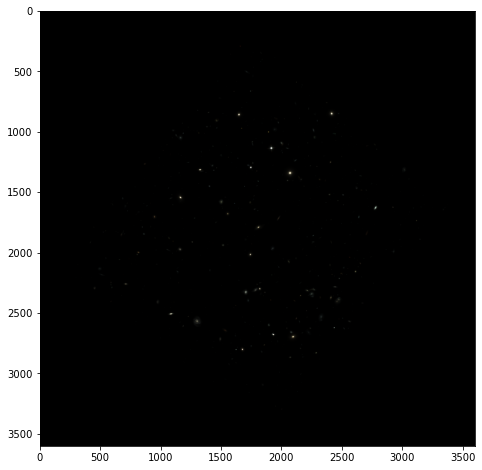

In [41]:
# And if you want it as a graph, here it is
plt.imshow(RGBImage)

Done, very pretty!